# LSTM + Decision Tree Integration Demo

This notebook demonstrates a full pipeline for hard drive failure prediction using both LSTM (deep learning) and Decision Tree (CT) models.

You will:
- Train and test the LSTM model
- Train and test the Decision Tree model on raw data
- Generate LSTM predictions for all drives
- Test a random drive using the LSTM model
- Feed the LSTM results into the Decision Tree and analyze the outcome

**Requirements:**  
- All dependencies installed (see `requirements.txt`)
- Data available in `data`
- LSTM and CT code available in `notebooks/LSTM/smart.py` and `notebooks/CT/CT.py`


In [1]:
# Step 1: Setup and Imports

import os
import sys
from typing import Optional
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import joblib
import json
from datetime import datetime


# Add project root and submodules to sys.path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), "../"))
sys.path.append(project_root)
sys.path.append(os.path.join(project_root, "notebooks/LSTM"))
sys.path.append(os.path.join(project_root, "notebooks/CT"))

import notebooks.LSTM.smart as smart
import notebooks.CT.CT as CT
from notebooks.LSTM.smart import Net

# Set device for torch: use GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Step 2: Load the data to train the models

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_existing = False # Change to True to test existing model
days_to_train = 3
days_to_predict = 2
min_sequence_length = days_to_train + days_to_predict
path = "../data/data_test"
verbose = True    # Create a single data loader that handles the train/test split properly
print(f'Using device: {device}')


Using device: cuda


In [ ]:

print("🔄 Loading and splitting data to prevent data leakage...")


train_loader, test_loader = smart.load_data(root=path,
                                        train_ratio=0.8, 
                                        min_sequence_length=min_sequence_length,
                                        input_len=days_to_train,
                                        label_len=days_to_predict,
                                        verbose=verbose)


# Step 3: Train the LSTM model

In [ ]:

num_features = 12
n_neurons = 4
num_epochs = 1
learning_rate = 0.001

# Check if trained model exists
model_path = 'models/LSTM/lstm_model.pth'

model, model_exists = smart.train_model(features = num_features,
            n_neurons = n_neurons,
            model_path = model_path,
            days_to_predict = days_to_predict,
            days_to_train = days_to_train,
            train_loader = train_loader,
            test_loader = test_loader,
            test_existing = test_existing,
            learning_rate = learning_rate,
            num_epochs = num_epochs)


shape: (torch.Size([3, 3, 12]), torch.Size([3, 2, 12]))
No saved model found. Training from scratch...


Training Progress: 100%|██████████| 1/1 [14:04<00:00, 844.49s/it]


✅ Complete model saved to models/LSTM/lstm_model.joblib
✅ Model metrics saved to models/LSTM/lstm_model_metrics.json
New best model saved with validation loss: 59318.017874
Epoch 1/1 - Train Loss: 71097.010561, Val Loss: 59318.017874
✅ Final loss curve saved to models/LSTM\final_loss.png


## Step 4: Generate predictions 

In [ ]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_targets = []

print("Generating final predictions...")
with torch.no_grad():
    for test_data, test_labels in tqdm(test_loader, desc="Generating predictions"):
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        predictions = model(test_data)
        test_predictions.append(predictions.cpu().numpy())
        test_targets.append(test_labels.cpu().numpy())

# Concatenate all predictions and targets
test_predictions = np.concatenate(test_predictions, axis=0)
test_targets = np.concatenate(test_targets, axis=0)

Generating final predictions...


Generating predictions: 100%|██████████| 19509/19509 [01:31<00:00, 213.08it/s]


# Step 5: Plot the results

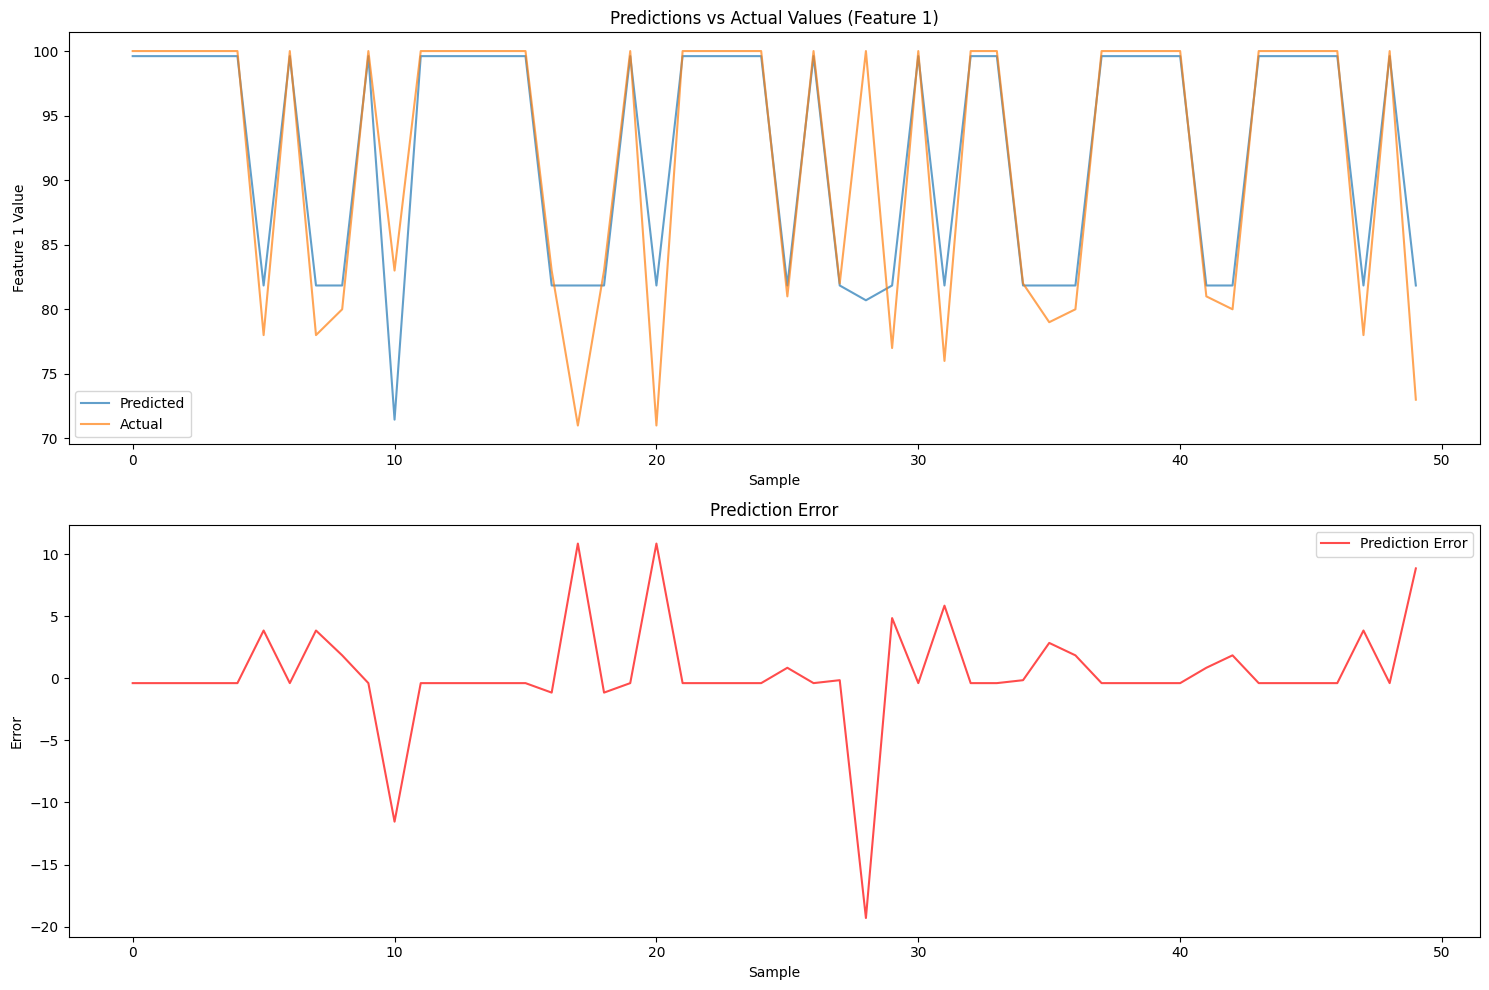

In [ ]:
# Plot predictions vs actual values for the first feature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot first few samples for visualization
num_samples_to_plot = min(50, len(test_predictions))
x = np.arange(num_samples_to_plot)

ax1.plot(x, test_predictions[:num_samples_to_plot, 0, 0], label='Predicted', alpha=0.7)
ax1.plot(x, test_targets[:num_samples_to_plot, 0, 0], label='Actual', alpha=0.7)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Feature 1 Value")
ax1.set_title("Predictions vs Actual Values (Feature 1)")
ax1.legend()

# Plot prediction error
error = test_predictions[:num_samples_to_plot, 0, 0] - test_targets[:num_samples_to_plot, 0, 0]
ax2.plot(x, error, label='Prediction Error', color='red', alpha=0.7)
ax2.set_xlabel("Sample")
ax2.set_ylabel("Error")
ax2.set_title("Prediction Error")
ax2.legend()
plt.tight_layout()

## Step 4: Train and Test the Decision Tree (CT) on Raw Data

We will now train and test the Decision Tree model using the raw SMART data.

### Step 4.1: Load the data to train the Decision Tree model

In [ ]:
data_path = "../data/data_test"
data = CT.importdata(data_path)

# Split dataset and apply SMOTE
X, Y, X_train_res, X_test, y_train_res, y_test = CT.splitdataset(data)

Processing CSV files: 100%|██████████| 6/6 [00:20<00:00,  3.47s/it]

Dataset Length:  390
Dataset Shape:  (390, 13)
Dataset:          failure  smart_1_normalized  smart_3_normalized  smart_5_normalized  \
246720    False               100.0                84.0               100.0   
60291     False                82.0                94.0               100.0   
107274    False               100.0               160.0               100.0   
233501    False                83.0                96.0               100.0   
106407     True               100.0               159.0               100.0   

        smart_5_raw  smart_7_normalized  smart_9_normalized  \
246720          0.0               100.0                98.0   
60291           0.0                79.0                67.0   
107274          0.0               100.0                94.0   
233501          0.0                82.0                72.0   
106407          3.0               100.0                94.0   

        smart_187_normalized  smart_189_normalized  smart_190_normalized  \
246720       


c:\Users\Green\miniconda3\envs\thesis\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Train both decision tree models

In [ ]:
print("\nTraining Decision Tree with Gini criterion...")
clf_gini = CT.train_using_gini(X_train_res, X_test, y_train_res)


Training Decision Tree with Gini criterion...


In [ ]:
print("\nTraining Decision Tree with Entropy criterion...")
clf_entropy = CT.train_using_entropy(X_train_res, X_test, y_train_res)


Training Decision Tree with Entropy criterion...


### Test models

In [ ]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)


Results Using Gini Index:
Predicted values:
[False False False False False False False False False  True  True False
 False  True False  True False False False False False False False False
 False False False False False False False False  True False False False
  True False  True False  True False False  True  True False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True False False False  True  True False False False False  True
  True False False False False False False  True False False  True False
 False  True False False False False False False False False  True False
  True False False False False  True False False False]
Confusion Matrix:  [[91  5]
 [ 3 18]]
Accuracy :  93.16239316239316
Report :                precision    recall  f1-score   support

       False       0.97      0.95      0.96        96
        True       0.78      0.86      0.82        21



In [ ]:
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini")

In [ ]:
print("\n" + "="*50)
print("Results Using Gini Index:")
print("="*50)
y_pred_gini = CT.prediction(X_test, clf_gini)
gini_accuracy = CT.cal_accuracy(y_test, y_pred_gini, clf_gini, "gini")

In [ ]:
print("\n" + "="*50)
print("Results Using Entropy:")
print("="*50)
y_pred_entropy = CT.prediction(X_test, clf_entropy)



Results Using Entropy:
Predicted values:
[False False False False False False False False False  True  True False
 False  True False  True False False False False False False False False
 False False False False False False False False  True False False False
  True False  True False  True False False  True  True False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
  True  True False False False  True  True False False False False  True
  True False False False False False False  True False False  True False
 False  True False False False False False False False False  True False
  True False False False False  True False False False]


In [ ]:
CT.cal_accuracy(y_test, y_pred_entropy, clf_entropy, "entropy")

### Save models

### Visualize the results

In [ ]:
smart_features = [f'smart_{i:03}' for i in range(1, 255)]

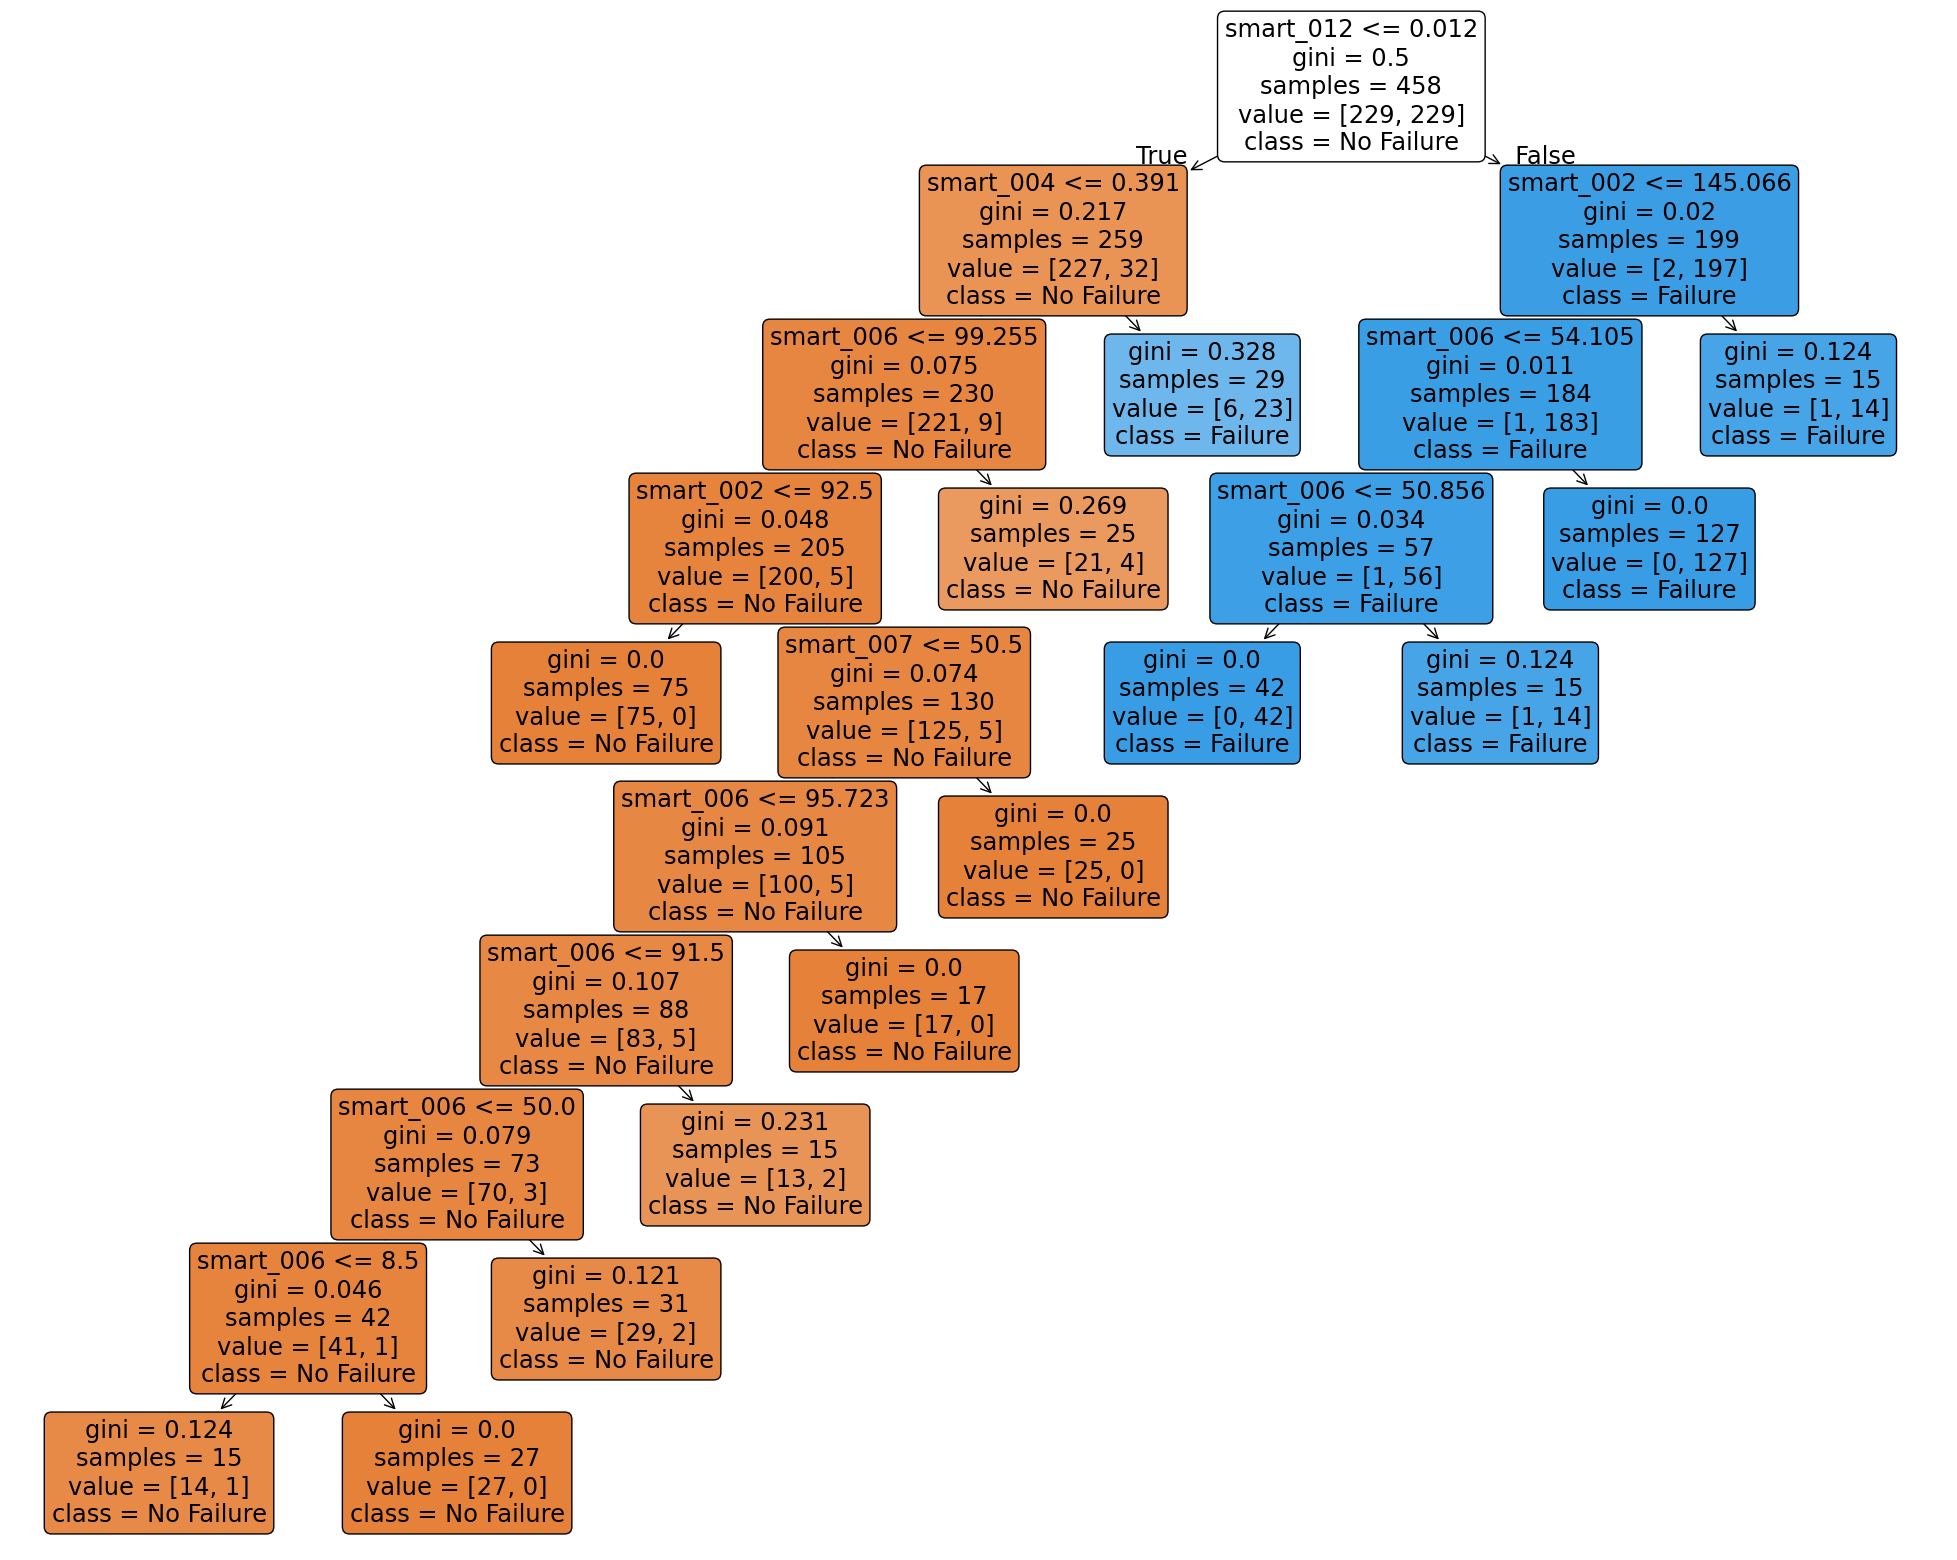

In [ ]:
CT.plot_decision_tree(clf_gini, smart_features, ['No Failure', 'Failure'])

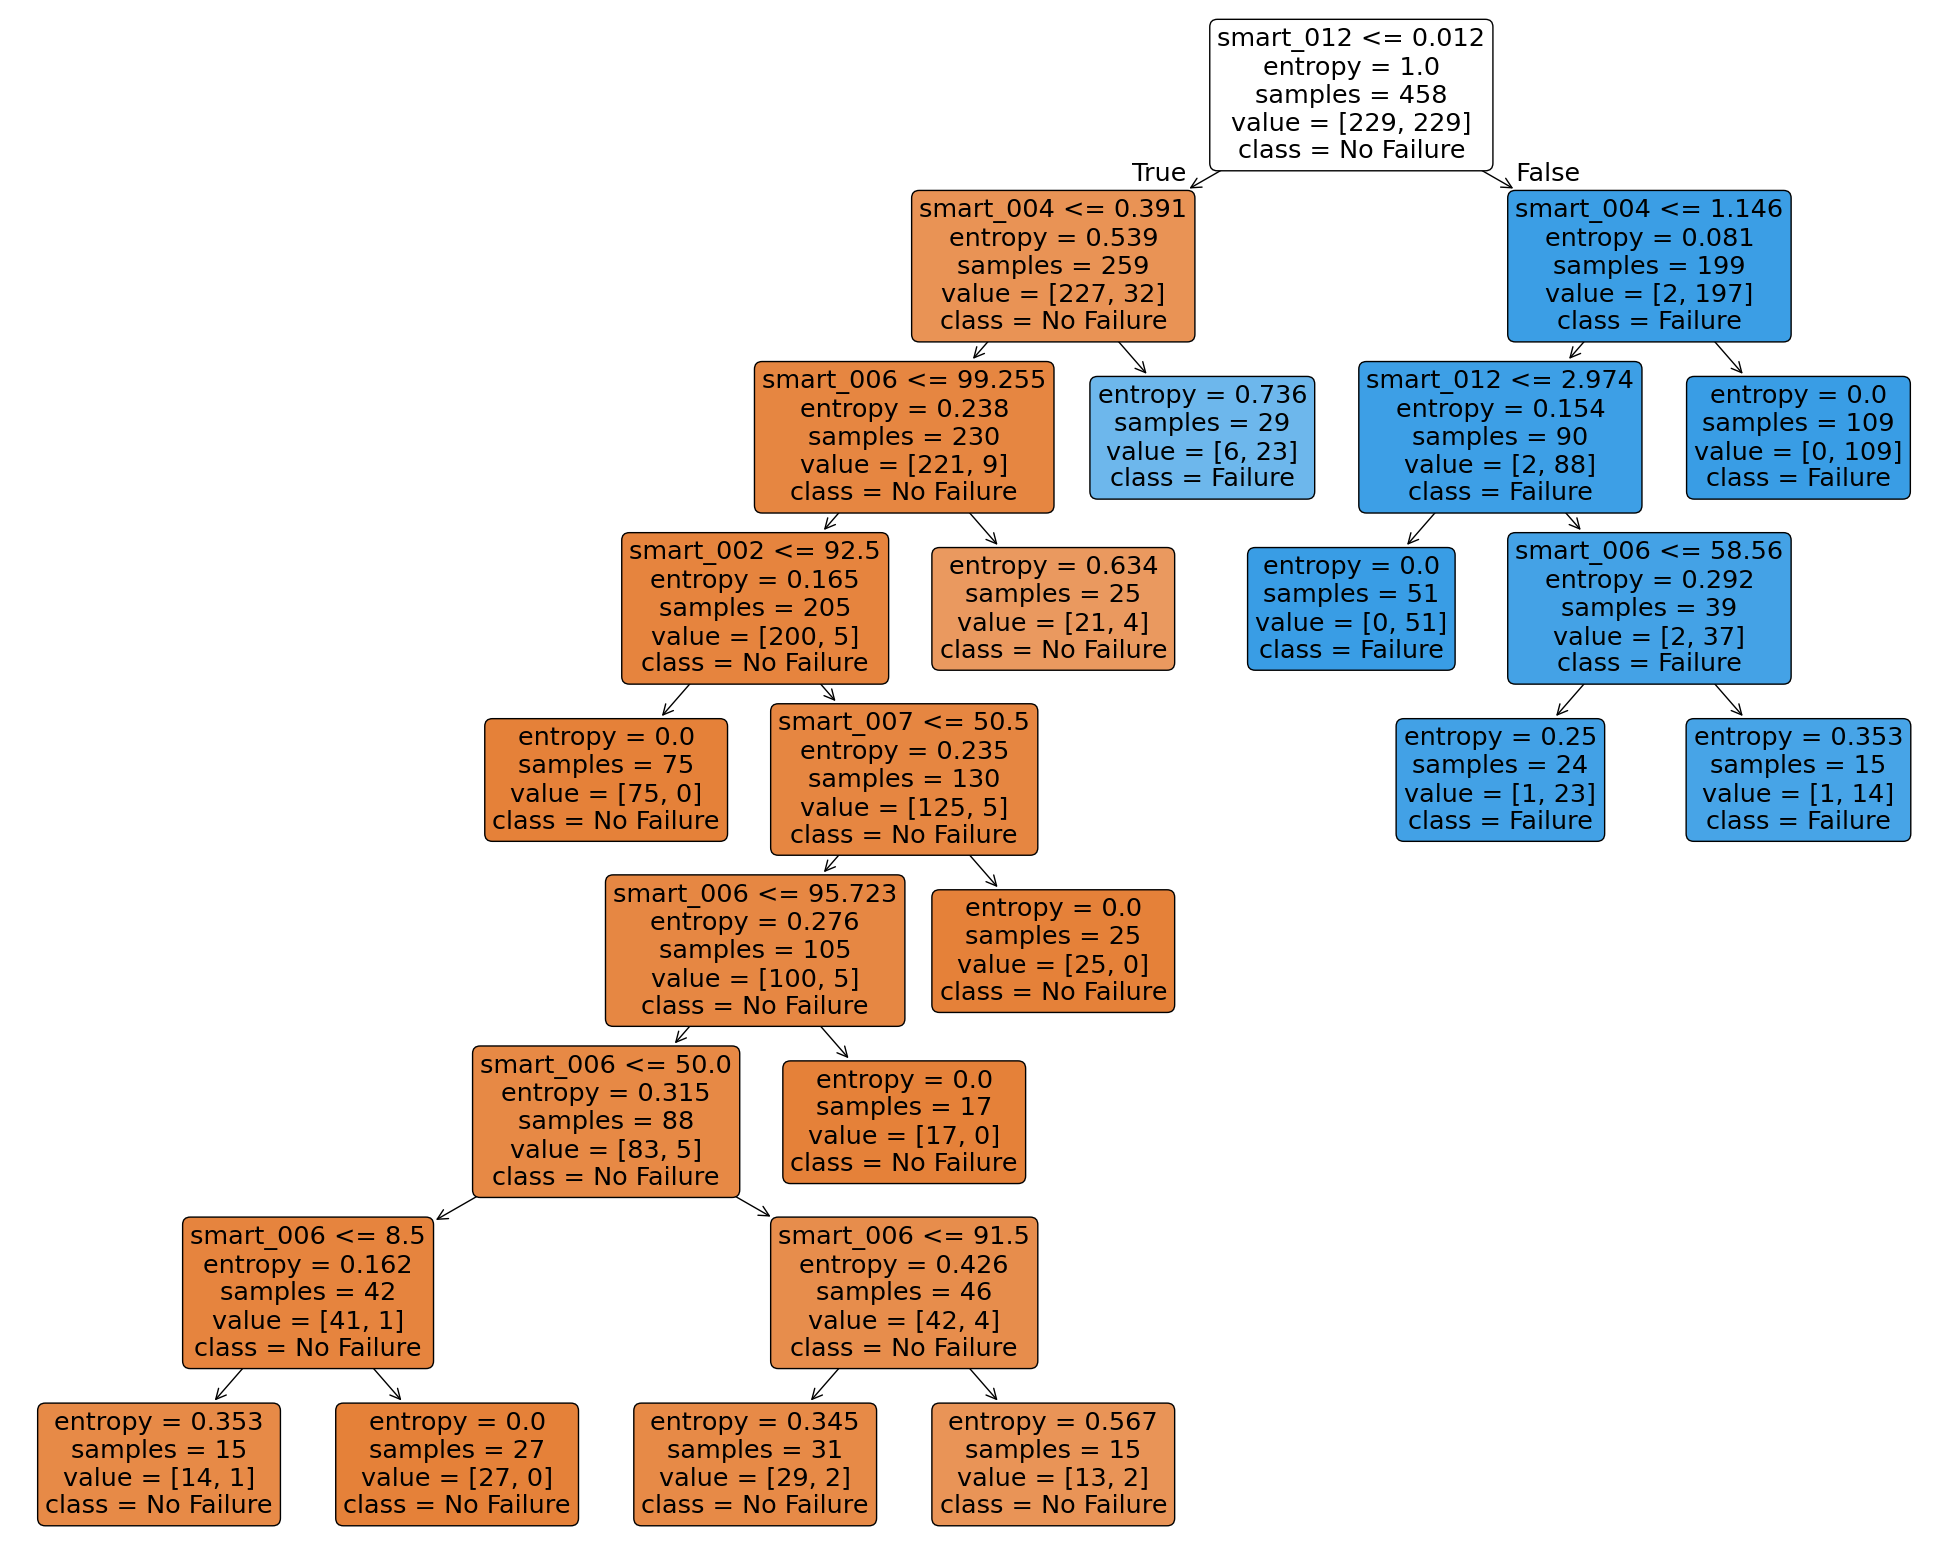

In [ ]:
CT.plot_decision_tree(clf_entropy, smart_features, ['No Failure', 'Failure'])

### Now we will predict a hard drive with the lstm and consume it and classify the prediction result with the CT

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_existing = True # Change to True to test existing model
path = "../data/data_test"
verbose = True    # Create a single data loader that handles the train/test split properly
print(f'Using device: {device}')

print("🔄 Loading and splitting data to prevent data leakage...")

Using device: cuda
🔄 Loading and splitting data to prevent data leakage...


In [5]:
model_path = 'models/LSTM/lstm_model.pth'
dataset_path = "../data/data_test"
output_path = "../pipeline/lstm_predictions_3drives_7days.csv"

# This will only select drives with at least 10 days of data, and predict 7 days for each
predictions_df = smart.generate_lstm_predictions(
    model_path=model_path,
    dataset_path=dataset_path,
    output_path=output_path,
    device=device,
    min_days_per_drive=min_sequence_length, # Min days has to be greater than days_to_predict
    days_to_predict=days_to_predict,
    num_drives_to_predict=days_to_train,
    verbose=True
)

[generate_lstm_predictions] Loading model from models/LSTM/lstm_model.pth on device cuda...
✅ Complete model loaded from models/LSTM/lstm_model.joblib
✅ Model metrics loaded from models/LSTM/lstm_model_metrics.json
[generate_lstm_predictions] Model loaded successfully from models/LSTM/lstm_model.pth
[DriveDataLoader] Found 0 subfolders in ../data/data_test.


Loading CSV files:  17%|█▋        | 1/6 [00:03<00:16,  3.40s/it]

Loaded ../data/data_test\2024-10-01.csv with shape (292679, 15)


Loading CSV files:  33%|███▎      | 2/6 [00:06<00:13,  3.36s/it]

Loaded ../data/data_test\2024-10-02.csv with shape (292648, 15)


Loading CSV files:  50%|█████     | 3/6 [00:10<00:10,  3.35s/it]

Loaded ../data/data_test\2024-10-03.csv with shape (292662, 15)


Loading CSV files:  67%|██████▋   | 4/6 [00:13<00:06,  3.33s/it]

Loaded ../data/data_test\2024-10-04.csv with shape (292694, 15)


Loading CSV files:  83%|████████▎ | 5/6 [00:16<00:03,  3.34s/it]

Loaded ../data/data_test\2024-10-05.csv with shape (292693, 15)


Loading CSV files: 100%|██████████| 6/6 [00:19<00:00,  3.33s/it]

Loaded ../data/data_test\2024-10-06.csv with shape (292683, 15)


[DriveDataLoader] Loaded 1756059 rows from all CSV files. DataFrame shape: (1756059, 15)
[DriveDataLoader] Found 292766 unique drives.
[DriveDataLoader] Filtering drives with minimum 5 days...
[DriveDataLoader] Valid drives (>= 5 days): 292624
[DriveDataLoader] Invalid drives (< 5 days): 142
[DriveDataLoader] Sequence length distribution of invalid drives:
[DriveDataLoader]   {1: np.int64(19), 2: np.int64(28), 3: np.int64(54), 4: np.int64(41)}
[DriveDataLoader] Split: 2926 drives for training, 289698 drives for testing.
[DriveDataLoader] Train ratio: 1.00%
[DriveDataLoader] Final dataset: 1755658 rows from 292624 valid drives.
[DriveDataLoader] Sample TRAIN drive 2GG3UKHD: 6 rows, dates 2024-10-01 to 2024-10-06
[DriveDataLoader] Sample TEST drive 1090A08UF9RG: 6 rows, dates 2024-10-01 to 2024-10-06
[DriveDataLoader] ✅ Verified: No drive overlap between train and test sets.

[DriveDataLoader] 📊 Sample drive verification:
[DriveDataLoader] 🚂 TRAIN sample - Drive 2GG3UKHD:
[DriveDataLoade

KeyError: 'serial_number'

In [ ]:

# Path to the new data you want to classify (e.g., pipeline output)
pipeline_data_path = "../pipeline/lstm_predictions_3drives_7days.csv"  # Change as needed

# Load the new data
pipeline_df = pd.read_csv(pipeline_data_path)
print("Pipeline data shape:", pipeline_df.shape)
print("Columns:", pipeline_df.columns.tolist())

# If your pipeline data includes non-feature columns, select only the feature columns
# For SMART features, you may need to adjust this selection based on your pipeline output
feature_cols = [col for col in pipeline_df.columns if "smart" in col and "normalized" in col]
if not feature_cols:
    # Fallback: use all columns except serial_number, prediction_day, etc.
    exclude_cols = ['serial_number', 'prediction_day', 'failure']
    feature_cols = [col for col in pipeline_df.columns if col not in exclude_cols]

X_pipeline = pipeline_df[feature_cols].values

# Load both best models
gini_model, gini_metrics = CT.load_best_model("gini", model_dir="models/DT")
entropy_model, entropy_metrics = CT.load_best_model("entropy", model_dir="models/DT")

# Classify the pipeline data
if gini_model is not None:
    gini_preds = gini_model.predict(X_pipeline)
    pipeline_df["gini_prediction"] = gini_preds
    print("Gini predictions:", gini_preds)
else:
    print("No Gini model found.")

if entropy_model is not None:
    entropy_preds = entropy_model.predict(X_pipeline)
    pipeline_df["entropy_prediction"] = entropy_preds
    print("Entropy predictions:", entropy_preds)
else:
    print("No Entropy model found.")

# Show results
pipeline_df[["serial_number"] + feature_cols + ["gini_prediction", "entropy_prediction"]].head()


Pipeline data shape: (6, 18)
Columns: ['serial_number', 'prediction_day', 'lstm_prediction_score', 'lstm_max_feature', 'lstm_min_feature', 'lstm_std_feature', 'lstm_pred_smart_1_normalized', 'lstm_pred_smart_3_normalized', 'lstm_pred_smart_5_normalized', 'lstm_pred_smart_7_normalized', 'lstm_pred_smart_9_normalized', 'lstm_pred_smart_187_normalized', 'lstm_pred_smart_189_normalized', 'lstm_pred_smart_190_normalized', 'lstm_pred_smart_195_normalized', 'lstm_pred_smart_197_normalized', 'lstm_pred_smart_5_raw', 'lstm_pred_smart_197_raw']


ValueError: X has 10 features, but DecisionTreeClassifier is expecting 12 features as input.